In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [138]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [139]:
import FinanceDataReader as fdr

In [140]:
kakao = fdr.DataReader('035720', '2015')#카카오 주가
kakao.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2023-04-13,58500,59600,58400,59500,1591961,0.013629
2023-04-14,60100,61000,59400,60500,2464952,0.016807
2023-04-17,60200,60700,59600,60100,1450046,-0.006612
2023-04-18,60200,60800,58900,59000,1731564,-0.018303
2023-04-19,59000,59100,58500,58600,1075270,-0.006780


<Axes: xlabel='Date', ylabel='Close'>

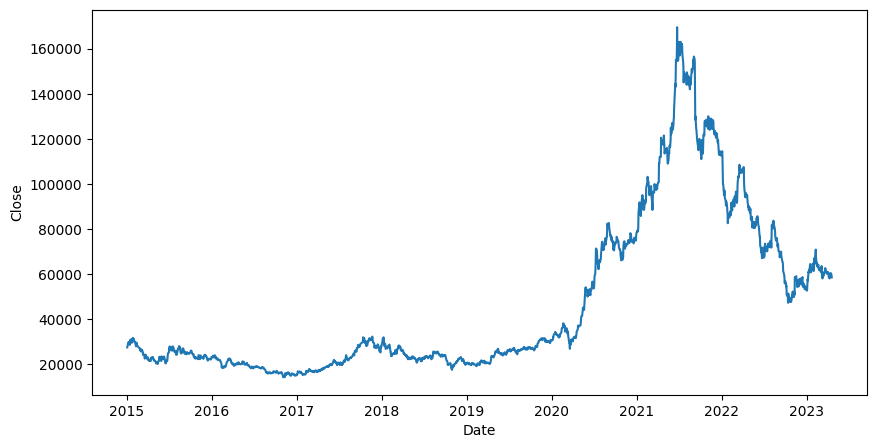

In [141]:
plt.figure(figsize=(10,5))
sns.lineplot(y=kakao['Close'], x=kakao.index)

##전처리

In [167]:
#종가만 사용
data = kakao[['Close']]

In [168]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

In [169]:
scaled.shape

(2044, 1)

In [170]:
X_train = scaled[:1500]
X_test = scaled[1500:]

In [171]:
import tensorflow as tf

def windowed_dataset(data, window_size, batch_size, shuffle):
  ds = tf.expand_dims(data, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(ds)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  if shuffle:
    ds = ds.shuffle(2000)
  ds = ds.map(lambda w: (w[:-1], w[-1]))
  return ds.batch(batch_size).prefetch(1)

In [172]:
WINDOW_SIZE = 20
BATCH_SIZE = 32

train_data = windowed_dataset(X_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(X_test, WINDOW_SIZE, BATCH_SIZE, False)

LSTM

In [173]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, GRU
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#conv층으로 flatten
model = Sequential([
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [177]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=loss, optimizer=optimizer, metrics=['mse'])

In [178]:

earlystopping = EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')
checkpoint_cb = ModelCheckpoint('finance.h5', save_best_only=True)


In [179]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=100000, 
                    callbacks=[checkpoint_cb, earlystopping])

Epoch 1/100000
47/47 [==============================] - 4s 18ms/step - loss: 2.4207e-05 - mse: 4.8413e-05 - val_loss: 0.0011 - val_mse: 0.0021
Epoch 2/100000
47/47 [==============================] - 1s 9ms/step - loss: 1.8643e-05 - mse: 3.7286e-05 - val_loss: 9.8054e-04 - val_mse: 0.0020
Epoch 3/100000
47/47 [==============================] - 1s 9ms/step - loss: 1.9561e-05 - mse: 3.9123e-05 - val_loss: 9.8002e-04 - val_mse: 0.0020
Epoch 4/100000
47/47 [==============================] - 1s 9ms/step - loss: 1.8114e-05 - mse: 3.6229e-05 - val_loss: 0.0011 - val_mse: 0.0021
Epoch 5/100000
47/47 [==============================] - 0s 9ms/step - loss: 1.7833e-05 - mse: 3.5666e-05 - val_loss: 8.3960e-04 - val_mse: 0.0017
Epoch 6/100000
47/47 [==============================] - 1s 9ms/step - loss: 1.8602e-05 - mse: 3.7205e-05 - val_loss: 8.5830e-04 - val_mse: 0.0017
Epoch 7/100000
47/47 [==============================] - 1s 9ms/step - loss: 1.8918e-05 - mse: 3.7836e-05 - val_loss: 9.0839e-04 - v

GRU모델

In [180]:
model2 = Sequential([
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    GRU(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [181]:
model2.compile(loss=loss, optimizer=Adam(0.0005), metrics=['mse'])

In [184]:
earlystopping2 = EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')
checkpoint_cb2 = ModelCheckpoint('finance2.h5', save_best_only=True)

In [185]:
history2 = model2.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=100000, 
                    callbacks=[checkpoint_cb2, earlystopping2])

Epoch 1/100000
47/47 [==============================] - 1s 10ms/step - loss: 1.8279e-05 - mse: 3.6559e-05 - val_loss: 3.6191e-04 - val_mse: 7.2381e-04
Epoch 2/100000
47/47 [==============================] - 1s 9ms/step - loss: 1.7879e-05 - mse: 3.5757e-05 - val_loss: 4.2601e-04 - val_mse: 8.5203e-04
Epoch 3/100000
47/47 [==============================] - 1s 10ms/step - loss: 1.9590e-05 - mse: 3.9179e-05 - val_loss: 3.2514e-04 - val_mse: 6.5028e-04
Epoch 4/100000
47/47 [==============================] - 1s 8ms/step - loss: 1.6794e-05 - mse: 3.3587e-05 - val_loss: 3.6870e-04 - val_mse: 7.3740e-04
Epoch 5/100000
47/47 [==============================] - 1s 8ms/step - loss: 2.0206e-05 - mse: 4.0413e-05 - val_loss: 5.0803e-04 - val_mse: 0.0010
Epoch 6/100000
47/47 [==============================] - 1s 13ms/step - loss: 1.9869e-05 - mse: 3.9737e-05 - val_loss: 3.7257e-04 - val_mse: 7.4514e-04
Epoch 7/100000
47/47 [==============================] - 1s 13ms/step - loss: 1.8087e-05 - mse: 3.6175

In [191]:
best_model = load_model('finance.h5')

In [192]:
pred = best_model.predict(test_data)

17/17 [==============================] - 0s 6ms/step


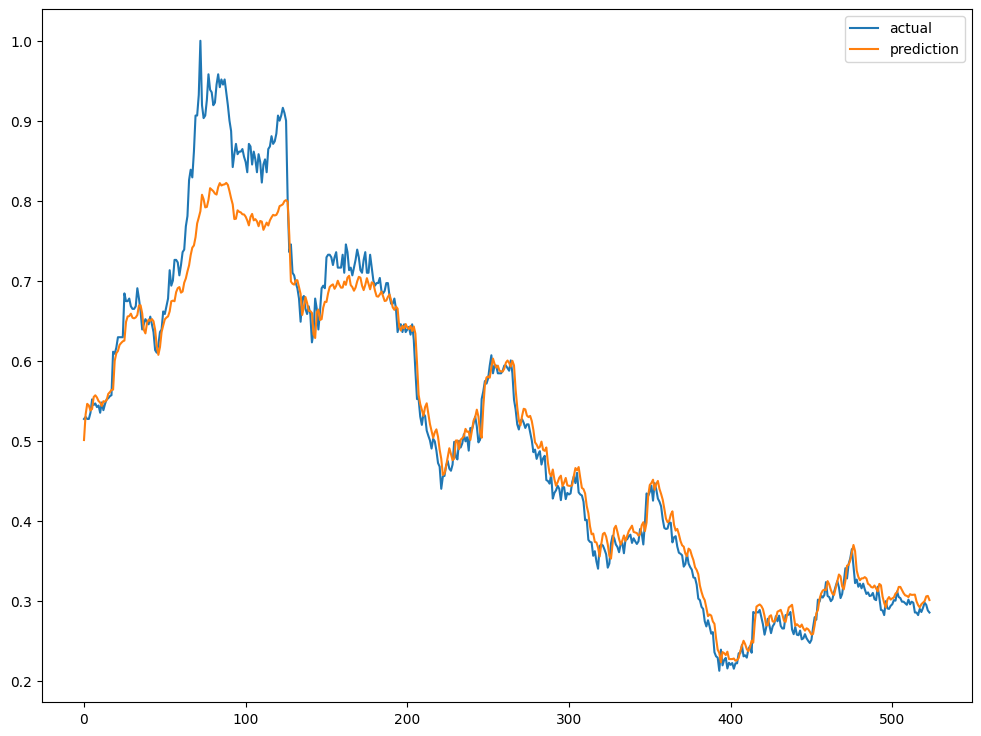

In [193]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(X_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [194]:
def finance_prediction(code, start):
  stock = fdr.DataReader(f'{code}', f'{start}')
  scaled = scaler.fit_transform(stock[['Close']])
  data_length = len(scaled)
  train_length = int(data_length * 0.8)
  X_train = scaled[:train_length]
  X_test = scaled[train_length:]
  train_data = windowed_dataset(X_train, WINDOW_SIZE, BATCH_SIZE, True)
  test_data = windowed_dataset(X_test, WINDOW_SIZE, BATCH_SIZE, False)
  model.fit(train_data, 
            validation_data=(test_data), 
            epochs=100000, 
            callbacks=[checkpoint_cb, earlystopping],
            verbose=0)
  best_model = load_model('finance.h5')
  pred = best_model.predict(test_data)
  plt.figure(figsize=(7, 5))
  plt.plot(np.asarray(X_test)[20:], label='actual')
  plt.plot(pred, label='prediction')
  plt.legend()
  plt.show()
  if pred[-1] >= X_test[-1]:
    print('익일 주가 상승예정')
  else:
    print('익일 주가 하락예정')


주식코드:AAPL
시작연도:2015
13/13 [==============================] - 0s 6ms/step


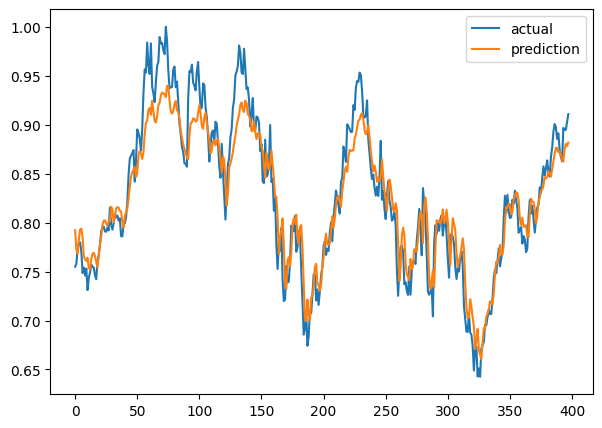

익일 주가 하락예정


In [195]:
finance_prediction(str(input('주식코드:')), str(input('시작연도:')))